<a href="https://colab.research.google.com/github/waynecday/IPUMSNHGISAPI/blob/master/NHGIS_2_getdata_2020_07_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IPUMS NHGIS API dataset extract request

This notebook adapts code provided by IPUMS and requests relevent data and shapefiles.

**See the IPUMS dataset extract API example here**:

https://developer.ipums.org/docs/workflows/create_extracts/nhgis_data/

This notebook requires that datasets, tables, variables of interest and other necessary paramaters are already determined. This information was captured in the prior notebook IKERST_1av1_nhgismetadata_YYYY-MM-DD.ipynb

**Data required**

Dataset(s): 2009 American Community Survey (ACS) 5-year estimates 

Geographic units: Block group and county level

Geographic extent: Galveston County, Texas

Fields of interest: Total population; total households; population by race and ethnicity; median household income

Shapefiles: block group and county geographies

# Preliminary Operations

#### 1. Install and import packages
#### 2. Mount Google Drive
#### 3. Set working directory

## 1.Install and import packages

In [ ]:
# Install packages not included in Google Colab by default
!pip install geopandas 

# Import packages
import os # for changing and creating directories
import requests # for getting data from the NHGIS API
import json # for building the NHGIS API request
from pprint import pprint # for checking the NHGIS API request operations
import sys  # for checking version of python for replication
import pandas as pd # for reading, writing and wrangling data
import geopandas as gpd # for creating maps and generally working with geospatial data
import folium as fm # folium has more dynamic maps - but requires internet connection

In [ ]:
# Display versions being used - important information for replication

print("Python Version     ", sys.version)
print("pandas version:    ", pd.__version__)
print("geopandas version: ", gpd.__version__)
print("folium version:    ", fm.__version__)
print("requests version:  ", requests.__version__)
print("json version:      ", json.__version__)

Python Version      3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
pandas version:     1.0.5
geopandas version:  0.8.1
folium version:     0.8.3
requests version:   2.23.0
json version:       2.0.9


## 2.Mount Google Drive

*Mounting* Google Drive allows you to read (write) files from (to) a Shared Google Drive or a Personal Google Drive. You will be required to run the following code block and enter an authorization code that will be provided.

See Google Colab documentation for further information: 
https://colab.research.google.com/notebooks/io.ipynb

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

## 3.Set working directory

The working directory will be created at the same level as this notebook with the same name as the notebook but without the .ipynb file suffix.

Mounting Google Drive is a prerequisite to running the following code blocks. This allows you to generate a working folder and write files to the working folder. 


Manually set the root_path folder to the location where this notebook resides in Google Drive. Then manually set programname to the same name as this notebook. Both root_path and programname are needed to generate the working directory folder.

In [ ]:
## manually set root_path and programname

root_path = '/content/drive/My Drive/Sandbox'
programname = "NHGIS_2_getdata_2020-07-29"

root_path_programname = root_path + "/" + programname
print("root_path:            ", root_path)
print("root_path_programname:", root_path_programname)

root_path:             /content/drive/My Drive/Sandbox
root_path_programname: /content/drive/My Drive/Sandbox/NHGIS_2_getdata_2020-07-29


In [ ]:
# change the working directory to root_path
os.chdir(root_path)
retval = os.getcwd()
print("Working directory set to: ", retval)

# Make directory to save output
if not os.path.exists(programname):
    os.mkdir(programname)
print("***programname folder created in root_folder***")

os.chdir(root_path_programname)
retval = os.getcwd()
print("Working directory set to: ", retval)

Working directory set to:  /content/drive/My Drive/Sandbox
***programname folder created in root_folder***
Working directory set to:  /content/drive/My Drive/Sandbox/NHGIS_2_getdata_2020-07-29


# NHGIS API dataset extract request

The following steps are required to submit a data extract reqeuest, retreive and download the data, and unzip the files in the working directory.

#### 1. Set API key
#### 2. Submit extract request
#### 3. Obtain historical extract numbers
> 3a. Saved extract number, or

> 3b. Enter NHGIS extract number into URL getRequest
#### 4. Monitor extract request progress
#### 5. Download zipped data files using request URLs
#### 6. Unzip the datafiles

## 1.Set API key
Set object `my_key` equal to personal and unique NHGIS API key obtained from https://developer.ipums.org/docs/get-started/.

In [ ]:
## set my_key to personal API key

my_key = "typekeyhere"
my_headers = {"Authorization": my_key}
print("my_key is now set to:", my_key)

## 2.Submit extract request
To submit a data extract request you need to pass a valid JSON-formatted extract request. The names or parameters to use for values in the data extract request can be discovered via the metadata API request found in the **NHGIS_1_getmetadata_YYYY-MM-DD** notebook.


DATA EXTRACT REQUEST FIELDS

* **datasets**: An object where each key is the **name** of the requested dataset and each value is another object describing your selections for that dataset.
  * **data_tables**: (Required) A list of selected data table names.
  * **geog_levels**: (Required) A list of selected geographic level names.
  * **years**: A list of selected years. To select all years use **["*"]**. Only required when the dataset has multiple years.
  * **breakdown_values**: A list of selected breakdown values. Defaults to first breakdown value. If more than one is selected, then specify **breakdown_and_data_type_layout** at the root of the request body.
* **time_series_tables**: An object where each key is the **name** of the requested time series table and each value is another object describing your selections for that time series table.
  * **geog_levels**: (Required) A list of selected geographic level names.
* **shapefiles**: A list of selected shapefiles.
* **description**: A short description of your extract.
* **data_format**: The requested format of your data. Valid choices are: **csv_no_header**, **csv_header**, and **fixed_width**. **csv_header** adds a second, more descriptive header row. Contrary to the name, **csv_no_header** still provides a minimal header in the first row. Required when any **datasets** or **time_series_tables** are selected.
* **breakdown_and_data_type_layout**: The layout of your dataset data when multiple data types or breakdown combos are present. Valid choices are: **separate_files** (split up each data type or breakdown combo into its own file) and **single_file** (keep all datatypes and breakdown combos in one file). Required when a dataset has multiple breakdowns or data types.
* **time_series_table_layout**: The layout of your time series table data. Valid choices are: **time_by_column_layout**, **time_by_row_layout**, and **time_by_file_layout**. Required when any time series tables are selected. See the NHGIS documentation for more information.
* **geographic_extents**: A list of **geographic_instances** to use as extents for all datasets on this request. To select all extents, use **["*"]**. Only applies to geographic levels where **has_geog_extent_selection** is true. Required when a geographic level on a dataset is specified where **has_geog_extent_selection** is true.

These are the required datasets, shapefiles and associated parameters determined using the metadata API in the  **NHGIS_1_getmetadata_YYYY-MM-DD** notebook. The were copied and pasted below for documentation purposes.


```
{'description': '5-Year Data [2005-2009, Block Groups & Larger Areas]',
  'group': '2009 American Community Survey',
  'name': '2005_2009_ACS5a',
  'sequence': 4603},

'data_tables': [{'description': 'Total Population',
                  'name': 'B01003',
                  'nhgis_code': 'RK9',
                  'sequence': 14},
				{'description': 'Hispanic or Latino Origin by Race',
                  'name': 'B03002',
                  'nhgis_code': 'RLI',
                  'sequence': 23},
				{'description': 'Median Household Income in the Past 12 '
                                 'Months (in 2009 Inflation-Adjusted Dollars)',
                  'name': 'B19013',
                  'nhgis_code': 'RNH',
                  'sequence': 94},				  
				{'description': 'Household Type (Including Living Alone)',
                  'name': 'B11001',
                  'nhgis_code': 'RL4',
                  'sequence': 45}]

'geog_levels': [{'description': 'State--County',
                  'has_geog_extent_selection': False,
                  'name': 'county',
                  'sequence': 25},
				{'description': 'State--County--Census Tract--Block Group',
                  'has_geog_extent_selection': True,
                  'name': 'blck_grp',
                  'sequence': 83}]

'geographic_instances': [{'description': 'Texas', 'name': '480'}]
'breakdown_values': [{'description': 'Total area', 'name': 'bs32.ge00'}]
```

These are the required 2009 TIGER/Line + shapefiles. 

```
"480_blck_grp_2000_tl2009" "us_county_2009_tl2009"
```
Note: While IPUMS NHGIS has various **time series** datasets available, we will not be requesting any time series datasets. As a consequence, any related time series code is not shown. 

Please see the IPUMS NHGIS documentation constructing a [time series metadata request](https://developer.ipums.org/docs/workflows/explore_metadata/nhgis/time_series/) or a [time series data request](https://developer.ipums.org/docs/workflows/create_extracts/nhgis_data/). 



### Manually formated extract request

The request is JSON formatted manually. 

A successful request will return a response that includes an extract number in the `my_extract_number` attribute.

In [ ]:
# manually formated extract request

my_headers = {"Authorization": my_key}
url = "https://api.ipums.org/extracts/?product=nhgis&version=v1"
er = """

{
  "datasets": {
    "2005_2009_ACS5a": {
      "years": [],
      "breakdown_values": [],
      "data_tables": [
        "B01003", "B03002", "B19013", "B11001"
      ],
      "geog_levels": [
        "blck_grp", "county"
      ]
    }
  },
  "shapefiles": [
    "480_blck_grp_2000_tl2009", "us_county_2009_tl2009"
  ],
  "geographic_extents": ["480"],
  "data_format": "csv_no_header",
  "description": "By blockgroup for Texas: Population counts, households counts, ethnicity by race counts, median household income",
  "breakdown_and_data_type_layout": "single_file"
}

"""
result = requests.post(url, headers=my_headers, json=json.loads(er))
my_extract_number = result.json()["number"]
print("my_extract_number:", my_extract_number)

my_extract_number: 21


## 3.Obtain historical extract numbers

You may also find it useful to get a historical listing of your extract requests. For example, if you have already submitted the data request but have foregotten the extract number. 

If you omit an extract number in your API call, by default this will return the 10 most recent extract requests. To adjust the amount returned, you may optionally specify a **?limit=##** parameter to get the ## most recent extracts instead.

In [ ]:
### Recent Extracts Request

r1 = requests.get(
    "https://api.ipums.org/extracts?product=nhgis&version=v1",
    headers=my_headers
)

pprint(r1.json())

[{'breakdown_and_data_type_layout': 'single_file',
  'data_format': 'csv_header',
  'datasets': {'2005_2009_ACS5a': {'breakdown_values': ['bs32.ge00'],
                                   'data_tables': ['B01003',
                                                   'B03002',
                                                   'B11001',
                                                   'B19013'],
                                   'geog_levels': ['blck_grp', 'county']}},
  'description': 'By blockgroup for Texas: Population counts, households '
                 'counts, ethnicity by race counts, median household income',
  'geographic_extents': ['480'],
  'number': 21,
  'shapefiles': ['480_blck_grp_2000_tl2009', 'us_county_2009_tl2009'],
  'status': 'started'},
 {'breakdown_and_data_type_layout': 'single_file',
  'data_format': 'csv_header',
  'datasets': {'2005_2009_ACS5a': {'breakdown_values': ['bs32.ge00'],
                                   'data_tables': ['B01003',
                 

## 4.Extract request progress

After submitting your extract request (as completed in section **2.Submit extract request**), you can use the extract number to retrieve the request’s status. 

Manually add the extract number to the URL. For example, the URL for extract number 56 would be:
 
https://api.ipums.org/extracts/56?product=nhgis&version=v1

Possible status are:
* `queued`
* `started`
* `produced`
* `canceled`
* `failed` 
* `completed`

When the `status` attribute is `completed`, the files will be ready for download.

Rerun this block of code until `status` is `completed`.



In [ ]:
## manually add the extract number to the URL

r = requests.get(
   "https://api.ipums.org/extracts/21?product=nhgis&version=v1",
    headers=my_headers
)

pprint(r.json())

{'breakdown_and_data_type_layout': 'single_file',
 'data_format': 'csv_header',
 'datasets': {'2005_2009_ACS5a': {'breakdown_values': ['bs32.ge00'],
                                  'data_tables': ['B01003',
                                                  'B03002',
                                                  'B11001',
                                                  'B19013'],
                                  'geog_levels': ['blck_grp', 'county']}},
 'description': 'By blockgroup for Texas: Population counts, households '
                'counts, ethnicity by race counts, median household income',
 'download_links': {'codebook_preview': 'https://data2.nhgis.org/extracts/867a4890-53fd-0138-73df-0242ac180004/21/nhgis0021_csv_PREVIEW.zip',
                    'gis_data': 'https://data2.nhgis.org/extracts/867a4890-53fd-0138-73df-0242ac180004/21/nhgis0021_shape.zip',
                    'table_data': 'https://data2.nhgis.org/extracts/867a4890-53fd-0138-73df-0242ac180004/21/nhgis0

## 5.Download data files using request URLs

Extract the download URL from the response, which is in the download_links attribute.

In [ ]:
extract = r.json()
my_extract_links = extract["download_links"]

print(my_extract_links)

{'codebook_preview': 'https://data2.nhgis.org/extracts/867a4890-53fd-0138-73df-0242ac180004/21/nhgis0021_csv_PREVIEW.zip', 'table_data': 'https://data2.nhgis.org/extracts/867a4890-53fd-0138-73df-0242ac180004/21/nhgis0021_csv.zip', 'gis_data': 'https://data2.nhgis.org/extracts/867a4890-53fd-0138-73df-0242ac180004/21/nhgis0021_shape.zip'}


Verify that the working directory is set correctly. This should have been completed earlier when mounting the notebook to Google Drive and setting the working directory.

In [ ]:
os.getcwd()

'/content/drive/My Drive/Sandbox/NHGIS_2_getdata_2020-07-29'

Download the zip files to the working directory.

In [ ]:
## manually set the names for the zip files as found in the URL extract links

r = requests.get(my_extract_links["codebook_preview"], allow_redirects=True)
open("nhgis0021_csv_PREVIEW.zip", "wb").write(r.content)

r = requests.get(my_extract_links["table_data"], allow_redirects=True)
open("nhgis0021_csv.zip", "wb").write(r.content)

r = requests.get(my_extract_links["gis_data"], allow_redirects=True)
open("nhgis0021_shape.zip", "wb").write(r.content)

print("Files downloaded from IPUMS NHGIS to the working directory")

Files downloaded from IPUMS NHGIS to the working directory


## 6.Unzip the datafiles
Now that the files have been downloaded from IPUMS NHGIS to the working directory, they can be unzipped.

In [ ]:
## manually set the names for the zip files found in the working directory

# Ignoring the PREVIEW.zip file which contains codebooks only. These codebooks are duplicated in the csv.zip file. 
# !unzip nhgis0021_csv_PREVIEW.zip

!unzip nhgis0021_csv.zip
!unzip nhgis0021_shape.zip

Archive:  nhgis0021_csv.zip
  inflating: nhgis0021_csv/nhgis0021_ds195_20095_2009_blck_grp.csv  
  inflating: nhgis0021_csv/nhgis0021_ds195_20095_2009_county_codebook.txt  
  inflating: nhgis0021_csv/nhgis0021_ds195_20095_2009_blck_grp_codebook.txt  
  inflating: nhgis0021_csv/nhgis0021_ds195_20095_2009_county.csv  
Archive:  nhgis0021_shape.zip
  inflating: nhgis0021_shape/nhgis0021_shapefile_tl2009_us_county_2009.zip  
  inflating: nhgis0021_shape/nhgis0021_shapefile_tl2009_480_blck_grp_2000.zip  


The shapefile extract `nhgis0020_shape` contains two child zip files: 
* `nhgis0020_shapefile_tl2009_480_blck_grp_2000.zip` for Texas block groups
* `nhgis0020_shapefile_tl2009_us_county_2009.zip` for US counties 

Manually extract these shapefiles by identifying the *relative* zipfile path. 

Remember, since the working folder was set earlier, relative paths can be used. The working directory is a folder created at the same level as this notebook with the same name minus the .ipynb suffix.

In [ ]:
## manually set the name for the zipfiles and the destination folder

!unzip nhgis0021_shape/nhgis0021_shapefile_tl2009_480_blck_grp_2000.zip -d nhgis0021_shape
!unzip nhgis0021_shape/nhgis0021_shapefile_tl2009_us_county_2009.zip -d nhgis0021_shape

Archive:  nhgis0021_shape/nhgis0021_shapefile_tl2009_480_blck_grp_2000.zip
  inflating: nhgis0021_shape/TX_blck_grp09_2000.dbf  
  inflating: nhgis0021_shape/TX_blck_grp09_2000.prj  
  inflating: nhgis0021_shape/TX_blck_grp09_2000.sbn  
  inflating: nhgis0021_shape/TX_blck_grp09_2000.sbx  
  inflating: nhgis0021_shape/TX_blck_grp09_2000.shp  
  inflating: nhgis0021_shape/TX_blck_grp09_2000.shp.xml  
  inflating: nhgis0021_shape/TX_blck_grp09_2000.shx  
Archive:  nhgis0021_shape/nhgis0021_shapefile_tl2009_us_county_2009.zip
  inflating: nhgis0021_shape/US_county_2009.dbf  
  inflating: nhgis0021_shape/US_county_2009.prj  
  inflating: nhgis0021_shape/US_county_2009.sbn  
  inflating: nhgis0021_shape/US_county_2009.sbx  
  inflating: nhgis0021_shape/US_county_2009.shp  
  inflating: nhgis0021_shape/US_county_2009.shp.xml  
  inflating: nhgis0021_shape/US_county_2009.shx  


# Data extraction complete 
All data has now been extracted and is available in the working directory.

The working directory should contain the following folders and files: 

```
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29\nhgis0021_csv
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29\nhgis0021_csv\nhgis0021_ds195_20095_2009_blck_grp.csv
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29\nhgis0021_csv\nhgis0021_ds195_20095_2009_blck_grp_codebook.txt
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29\nhgis0021_csv\nhgis0021_ds195_20095_2009_county.csv
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29\nhgis0021_csv\nhgis0021_ds195_20095_2009_county_codebook.txt
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29\nhgis0021_shape
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29\nhgis0021_shape\nhgis0021_shapefile_tl2009_480_blck_grp_2000.zip
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29\nhgis0021_shape\nhgis0021_shapefile_tl2009_us_county_2009.zip
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29\nhgis0021_shape\TX_blck_grp09_2000.shp
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29\nhgis0021_shape\US_county_2009.shp
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29\nhgis0021_csv.zip
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29\nhgis0021_csv_PREVIEW.zip
My Drive\Sandbox\NHGIS_2_getdata_2020-07-29\nhgis0021_shape.zip
```



The following portions of this notebook show off some of the data. 

In [ ]:
os.getcwd()

'/content/drive/My Drive/Sandbox/NHGIS_2_getdata_2020-07-29'

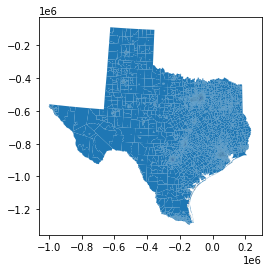

In [ ]:
## manually set shapefile

tx_blck_grp09_2000_shp = 'nhgis0021_shape/TX_blck_grp09_2000.shp'
texasbg = gpd.read_file(tx_blck_grp09_2000_shp)
texasbg.plot()

In [ ]:
texasbg.head()

,STATEFP00,COUNTYFP00,TRACTCE00,BLKGRPCE00,BKGPIDFP00,NAMELSAD00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,GISJOIN,SHAPE_AREA,SHAPE_LEN,geometry
0,48,243,950100,3,482439501003,Block Group 3,G5030,S,47731289.0,0.0,+30.6011912,-103.8627828,G48024309501003,4.773128e+07,43473.980484,"POLYGON ((-748124.252 -734670.419, -748085.580..."
1,48,463,950300,3,484639503003,Block Group 3,G5030,S,1458434.0,0.0,+29.2202971,-099.7963029,G48046309503003,1.458435e+06,5152.042933,"POLYGON ((-368887.083 -915895.621, -368805.349..."
2,48,463,950300,4,484639503004,Block Group 4,G5030,S,565573.0,0.0,+29.2112554,-099.7913176,G48046309503004,5.655734e+05,3016.113379,"POLYGON ((-368313.944 -917706.508, -368392.683..."
3,48,463,950200,1,484639502001,Block Group 1,G5030,S,403578750.0,3662684.0,+29.3437230,-099.6665918,G48046309502001,4.072414e+08,105873.882836,"POLYGON ((-360746.733 -885827.727, -360705.347..."
4,48,019,980200,2,480199802002,Block Group 2,G5030,S,605656901.0,1474566.0,+29.7300214,-099.3762748,G48001909802002,6.071314e+08,119114.354761,"POLYGON ((-316077.895 -854641.582, -316101.541..."


In [ ]:
texasbg.describe()

,ALAND00,AWATER00,SHAPE_AREA,SHAPE_LEN
count,1.446200e+04,1.446200e+04,1.446200e+04,1.446200e+04
mean,4.678349e+07,1.318660e+06,4.740868e+07,1.806505e+04
std,2.647472e+08,2.074341e+07,2.656364e+08,3.900664e+04
min,4.530100e+04,0.000000e+00,4.530170e+04,8.887285e+02
25%,5.780260e+05,0.000000e+00,5.810788e+05,3.476861e+03
50%,1.188162e+06,0.000000e+00,1.200496e+06,5.328836e+03
75%,6.461754e+06,3.713800e+04,6.683460e+06,1.334280e+04
max,9.519795e+09,1.262250e+09,9.520285e+09,1.649714e+06
